## Deploying bucketed SDXL image-to-image on inferencia2 instance

1) 코드 작성의 배경

    SDXL 모델은 1024x1024 픽셀로 입출력 이미지의 사이즈가 고정되어 있습니다. 이로 인해 1024x1024 pixel 사이즈보다 작은 이미지를 입력 프롬프트로 받게 되는 경우에도, 이미지에 패딩을 적용하여 1024x1024로 확대한 후, 모델을 구동시켜, 패딩 영역에 대한 불필요한 연산을 수행해야만 합니다. 이는 컴퓨팅 리소스 및 동작 시간에 있어서 손실로 이어집니다.

    버켓팅(Bucketing)은 SDXL 모델의 입출력 이미지의 사이즈를 몇단계로 구분하여, 다양한 사이즈의 입력 이미지에 대하여 가장 유사한 입출력 이미지를 갖는 SDXL 모델로 구동시키는 방법입니다. 이를 통해 입력 이미지에 대한 패딩 영역을 최소화할 수 있고, 이는 컴퓨팅 리소스 및 동작 시간 절감을 가능케 합니다. 이에 대한 자세한 설명은 다음 링크를 참고하시기 바랍니다. 
    https://awsdocs-neuron.readthedocs-hosted.com/en/latest/general/appnotes/torch-neuron/bucketing-app-note.html

    본 코드에서는 512x512 픽셀과 1024x1024 픽셀의 입출력 이미지에 대하여 버켓팅된 두개의 SDXL 모델을 컴파일하여 각각의 Neuron 모델을 생성하고, 이를 inferentia2 인스턴스에서 구동하는 방법을 설명합니다. 본 예제에서는 HuggingFace의 stabilityai/stable-diffusion-xl-refiner-1.0 모델과 EC2의 inf2.24xlarge 인스턴스를 사용하였습니다.

2) 환경 설정 1

    시작에 앞서 Inf2 셋업 가이드에 따라 EC2 인스턴스에 `torch-neuronx` 와 `neuronx-cc` 를 설치해야합니다. 
    이에 관한 자세한 설명을 다음 링크를 참고하시기 바랍니다.
    https://awsdocs-neuron.readthedocs-hosted.com/en/latest/general/setup/torch-neuronx.html#setup-torch-neuronx

3) 환경 설정 2

    본 예제에서는 다음의 pip 패키지가 추가로 요구됩니다. 
    - `diffusers==0.20.0`
    - `transformers==4.26.1`
    - `accelerate==0.16.0`
    - `matplotlib`
    - `PIL`

In [1]:
%env TOKENIZERS_PARALLELISM=True #Supresses tokenizer warnings making errors easier to detect
!pip install diffusers==0.20.0 transformers==4.26.1 accelerate==0.16.0 matplotlib

env: TOKENIZERS_PARALLELISM=True #Supresses tokenizer warnings making errors easier to detect


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


4) 코드 구동에 필요한 패키지를 임포트합니다.

In [2]:
import os
 
import numpy as np
import torch
import torch.nn as nn
import torch_neuronx
from diffusers import StableDiffusionXLImg2ImgPipeline, StableDiffusionXLPipeline, AutoPipelineForImage2Image
from diffusers.models.unet_2d_condition import UNet2DConditionOutput
from diffusers.models.attention_processor import Attention
 
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import time
import copy
from IPython.display import clear_output

clear_output(wait=False)

5) SDXL 모델 내 주요 뉴럴 네트워크 모듈을 분리하여 컴파일하기 위한 클래스 및 함수를 사전 정의합니다.

In [3]:
def get_attention_scores_neuron(self, query, key, attn_mask):    
    if(query.size() == key.size()):
        attention_scores = custom_badbmm(
            key,
            query.transpose(-1, -2),
            self.scale
        )
        attention_probs = attention_scores.softmax(dim=1).permute(0,2,1)

    else:
        attention_scores = custom_badbmm(
            query,
            key.transpose(-1, -2),
            self.scale
        )
        attention_probs = attention_scores.softmax(dim=-1)
  
    return attention_probs
 

def custom_badbmm(a, b, scale):
    bmm = torch.bmm(a, b)
    scaled = bmm * scale
    return scaled
 

class UNetWrap(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet
 
    def forward(self, sample, timestep, encoder_hidden_states, text_embeds=None, time_ids=None):
        out_tuple = self.unet(sample,
                              timestep,
                              encoder_hidden_states,
                              added_cond_kwargs={"text_embeds": text_embeds, "time_ids": time_ids},
                              return_dict=False)
        return out_tuple
    
    
class NeuronUNet(nn.Module):
    def __init__(self, unetwrap):
        super().__init__()
        self.unetwrap = unetwrap
        self.config = unetwrap.unet.config
        self.in_channels = unetwrap.unet.in_channels
        self.add_embedding = unetwrap.unet.add_embedding
        self.device = unetwrap.unet.device
 
    def forward(self, sample, timestep, encoder_hidden_states, added_cond_kwargs=None, return_dict=False, cross_attention_kwargs=None):
        sample = self.unetwrap(sample,
                               timestep.float().expand((sample.shape[0],)),
                               encoder_hidden_states,
                               added_cond_kwargs["text_embeds"],
                               added_cond_kwargs["time_ids"])[0]
        return UNet2DConditionOutput(sample=sample)

    

6) SDXL 모델의 내부 모듈 별 컴파일 및 저장

    하기 코드에서는 stabilityai/stable-diffusion-xl-refiner-1.0의 파이프라인을 pipe에 불러온 후, Unet과 Decoder, post_quant_conv 모듈로 구분하여 뉴런 모델로 컴파일하여 각각을 sdxl_img2img_compile_dir_1024 폴더 내에 저장합니다.
    stabilityai/stable-diffusion-xl-refiner-1.0은 1024x1024 픽셀 사이즈의 입력 이미지를 프롬프트로 받아 1/8로 다운 사이징 한 후, 각 모듈은 4x128x128 사이즈의 데이터를 입력 받습니다. 
    여기서는 384x384 픽셀 사이즈, 512x512 픽셀 사이즈, 768x768 픽셀 사이즈, 896x896 픽셀 사이즈, 1024x1024 픽셀 사이즈의 입력 이미지 각각에 대한 SDXL 모델을 뉴런 모델로 컴파일합니다.
    각 모듈은 1/8로 다운 사이징 된 데이터를 입력 받기에, 4x48x48 / 4x64x64 / 4x96x96 / 4x112x112 / 4x128x128 사이즈의 입력에 대하여 모듈을 각각 컴파일합니다.

In [ ]:
COMPILER_WORKDIR_ROOT = 'sdxl_img2img_compile_dir_1024'

# Model ID for SD XL version pipeline
refiner_model_id = "stabilityai/stable-diffusion-xl-refiner-1.0"

# Defining bucket sizes
bucket_sizes = [(48, 48), (64, 64), (96, 96), (112, 112), (128, 128)] #512/8=64, 1024/8=128

# --- Compile UNet (refiner) and save ---

pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_id, torch_dtype=torch.float32, low_cpu_mem_usage=True)

# Apply double wrapper to deal with custom return type
pipe.unet = NeuronUNet(UNetWrap(pipe.unet))

# Only keep the model being compiled in RAM to minimze memory pressure
unet_refiner = copy.deepcopy(pipe.unet.unetwrap)
del pipe

# Compile refiner unet - fp32 - some shapes are different than the base model
for bucket_size in bucket_sizes:    
    h, w = bucket_size
    sample_1b = torch.randn([1, 4, h, w])
    timestep_1b = torch.tensor(999).float().expand((1,))
    encoder_hidden_states_refiner_1b = torch.randn([1, 77, 1280])
    added_cond_kwargs_refiner_1b = {"text_embeds": torch.randn([1, 1280]),
                                    "time_ids": torch.randn([1, 5])}
    example_inputs = (sample_1b, timestep_1b, encoder_hidden_states_refiner_1b, added_cond_kwargs_refiner_1b["text_embeds"], added_cond_kwargs_refiner_1b["time_ids"],)

    unet_refiner_neuron = torch_neuronx.trace(
        unet_refiner,
        example_inputs,
        compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_unet_refiner'),
        compiler_args=["--model-type=unet-inference"]
    )

    # save compiled unet
    unet_refiner_filename = os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_unet_refiner/model.pt')
    torch.jit.save(unet_refiner_neuron, unet_refiner_filename)

# delete unused objects
del unet_refiner
del unet_refiner_neuron

# --- Compile VAE decoder and save ---

# Only keep the model being compiled in RAM to minimze memory pressure
pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_id, torch_dtype=torch.float32, low_cpu_mem_usage=True)
decoder = copy.deepcopy(pipe.vae.decoder)
del pipe

# # Compile vae decoder
for bucket_size in bucket_sizes:    
    h, w = bucket_size
    decoder_in = torch.randn([1, 4, h, w])
    decoder_neuron = torch_neuronx.trace(
        decoder, 
        decoder_in, 
        compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_vae_decoder'),
    )

    # Save the compiled vae decoder
    decoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_vae_decoder/model.pt')
    torch.jit.save(decoder_neuron, decoder_filename)

# delete unused objects
del decoder
del decoder_neuron

# --- Compile VAE post_quant_conv and save ---

# Only keep the model being compiled in RAM to minimze memory pressure
pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_id, torch_dtype=torch.float32, low_cpu_mem_usage=True)
post_quant_conv = copy.deepcopy(pipe.vae.post_quant_conv)
del pipe

# Compile vae post_quant_conv
for bucket_size in bucket_sizes:    
    h, w = bucket_size
    post_quant_conv_in = torch.randn([1, 4, h, w])
    post_quant_conv_neuron = torch_neuronx.trace(
        post_quant_conv, 
        post_quant_conv_in,
        compiler_workdir=os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_vae_post_quant_conv'),
    )

    # Save the compiled vae post_quant_conv
    post_quant_conv_filename = os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_vae_post_quant_conv/model.pt')
    torch.jit.save(post_quant_conv_neuron, post_quant_conv_filename)

# delete unused objects
del post_quant_conv
del post_quant_conv_neuron

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_12362/2870715719.py:46: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  self.in_channels = unetwrap.unet.in_channels
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ffb5b9a87f0>>
Traceback (most recent call last):
  File "/home/ec2-user/aws_neuron_venv_pytorch/lib64/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


7) 버켓팅된 SDXL 모델 구축
모듈 별로 생성된 뉴런 모델을 조합하여 384x384 픽셀 사이즈, 512x512 픽셀 사이즈, 768x768 픽셀 사이즈, 896x896 픽셀 사이즈, 1024x1024 픽셀 사이즈의 입력 이미지를 처리하기 위한 각각의 SDXL 모델을 재조합합니다.

In [5]:
bucket_sizes = [(48, 48), (64, 64), (96, 96), (112, 112), (128, 128)] #512/8=64, 1024/8=128

compiled_pipe_refiner = {}
idx = 0
for bucket_size in bucket_sizes:
    idx = idx + 1
    h, w = bucket_size
    # --- Load all compiled models ---
    COMPILER_WORKDIR_ROOT = 'sdxl_img2img_compile_dir_1024'
    refiner_model_id = "stabilityai/stable-diffusion-xl-refiner-1.0"

    unet_refiner_filename = os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_unet_refiner/model.pt')
    decoder_filename = os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_vae_decoder/model.pt')
    post_quant_conv_filename = os.path.join(COMPILER_WORKDIR_ROOT, str(h)+'_vae_post_quant_conv/model.pt')

    pipe_refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(refiner_model_id, torch_dtype=torch.float32, low_cpu_mem_usage=True)
  
    # Load the compiled UNet (base) onto two neuron cores.
    pipe_refiner.unet = NeuronUNet(UNetWrap(pipe_refiner.unet))
    if idx == 1:
        device_ids = [0,1]
    elif idx == 2:
        device_ids = [2,3]
    elif idx == 3:
        device_ids = [4,5]
    elif idx == 4:
        device_ids = [2,3]
    elif idx == 5:
        device_ids = [0,1]
    pipe_refiner.unet.unetwrap = torch_neuronx.DataParallel(torch.jit.load(unet_refiner_filename), device_ids, set_dynamic_batching=False)

    # Load other compiled models onto a single neuron core.
    pipe_refiner.vae.decoder = torch.jit.load(decoder_filename)
    pipe_refiner.vae.post_quant_conv = torch.jit.load(post_quant_conv_filename)

    compiled_pipe_refiner[bucket_size] = pipe_refiner

    del pipe_refiner

/home/ec2-user/aws_neuron_venv_pytorch/lib64/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_16585/2870715719.py:46: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  self.in_channels = unetwrap.unet.in_channels


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

8) 버켓 모델 선택 및 입력 이미지 패딩 관련 함수 정의

In [6]:
def get_bucket_and_pad_image(image):
    # Determine which bucket size to use
    oh, ow = image.size
    target_bucket = None
    for bucket_size in bucket_sizes:
        # Choose a bucket that's larger in both the height and width dimensions
        if oh <= bucket_size[0]*8 and ow <= bucket_size[1]*8:
            target_bucket = bucket_size
            break

    # Pad the image to match the size of the bucket
    h_delta = target_bucket[0]*8 - oh
    w_delta = target_bucket[1]*8 - ow
    
    b_pad = h_delta  # Bottom padding
    l_pad = 0  # Left padding
    t_pad = 0  # Top padding
    r_pad = w_delta  # Right padding

    # Pad the height and width of the image
    padding_amounts = (l_pad, b_pad, t_pad, r_pad)

    from torchvision import transforms
    to_tensor = transforms.ToTensor()
    image = to_tensor(image)
    
    image_padded = torch.nn.functional.pad(image, padding_amounts, value=0)

    return image_padded, target_bucket

9) 버켓팅된 SDXL 모델의 inf2.24xlarge 구동 테스트
    입력 이미지의 사이즈를 랜덤하게 변경하여, 각 사이즈에 따라 올바른 SDXL 모델이 선택되는지 확인한다.
    1024x1024 픽셀의 입출력 이미지를 처리하는 SDXL 모델의 동작 속도 2it/sec 대비, 512x512 픽셀의 입출력 이미지를 처리하는 SDXL 모델의 동작 속도는 14it/sec 로 상대적으로 높은 성능을 보임을 확인할 수 있다. 

input_image: (349x266) || selected model: (384x384)


  0%|          | 0/40 [00:00<?, ?it/s]

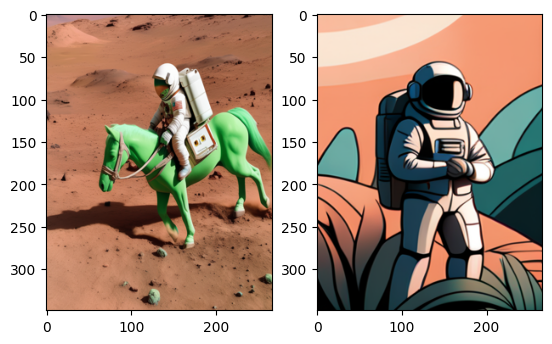

input_image: (400x237) || selected model: (512x512)


  0%|          | 0/40 [00:00<?, ?it/s]

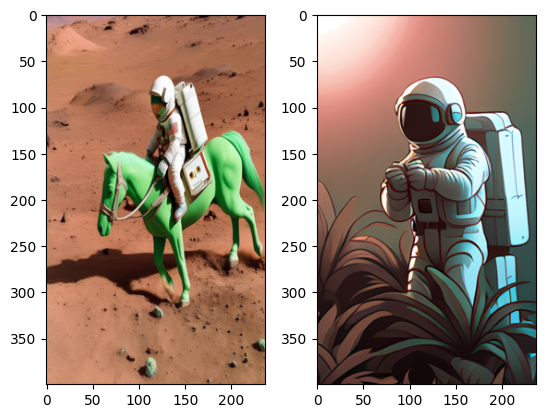

input_image: (294x465) || selected model: (512x512)


  0%|          | 0/40 [00:00<?, ?it/s]

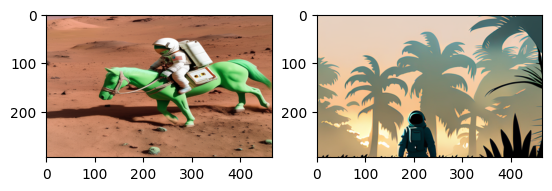

input_image: (303x326) || selected model: (384x384)


  0%|          | 0/40 [00:00<?, ?it/s]

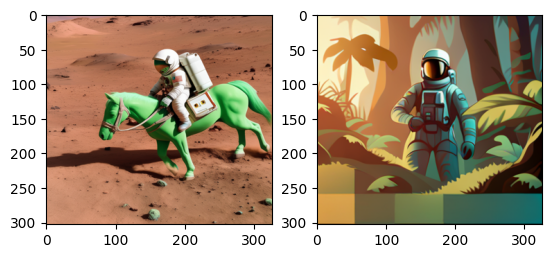

input_image: (373x430) || selected model: (512x512)


  0%|          | 0/40 [00:00<?, ?it/s]

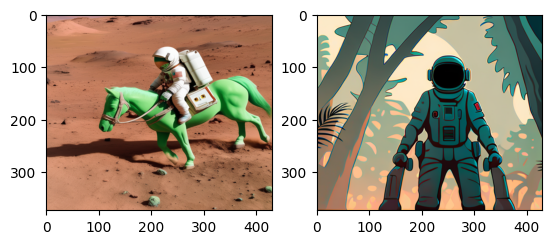

input_image: (456x230) || selected model: (512x512)


  0%|          | 0/40 [00:00<?, ?it/s]

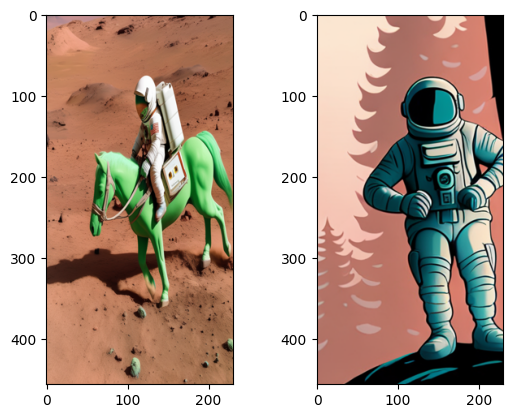

input_image: (334x331) || selected model: (384x384)


  0%|          | 0/40 [00:00<?, ?it/s]

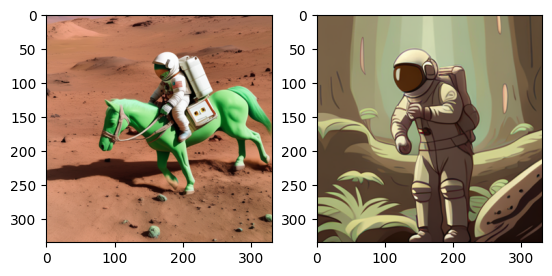

input_image: (316x229) || selected model: (384x384)


  0%|          | 0/40 [00:00<?, ?it/s]

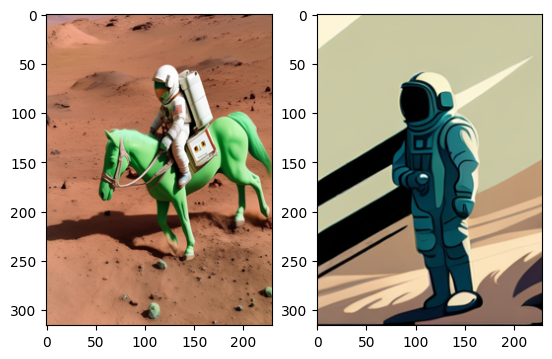

input_image: (415x310) || selected model: (512x512)


  0%|          | 0/40 [00:00<?, ?it/s]

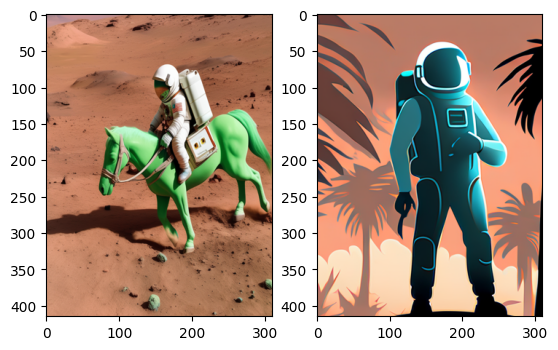

input_image: (484x216) || selected model: (512x512)


  0%|          | 0/40 [00:00<?, ?it/s]

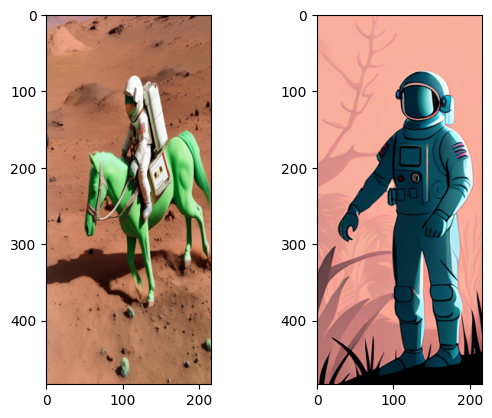

In [11]:
from PIL import Image

for _ in range(10):
    # Create an image with a random height and width in range [300, 300] to [1000, 1000]
    h = int(np.random.uniform(low=200, high=512))
    w = int(np.random.uniform(low=200, high=512))

    #image_init = Image.open("boy-riding-horse-with-face-center_391229-8370.jpg")

    image_init = Image.open("image_init.png")
    image_init
    image_init = image_init.resize((h, w))

    # Determine bucket and pad the image
    image_padded, target_bucket = get_bucket_and_pad_image(image_init)
    print("input_image: "+"("+str(w)+"x"+str(h)+")"+" || "+"selected model: "+"("+str(target_bucket[0]*8)+"x"+str(target_bucket[1]*8)+")")

    # First do a warmup run so all the asynchronous loads can finish
    image_warmup = compiled_pipe_refiner[target_bucket](prompt="Astronaut in a jungle, cold color palette, muted colors, detailed, 8k", image=image_padded, strength=0.8, guidance_scale=10.5).images[0]
    image_warmup.save("image_refiner.png")
    image = mpimg.imread("image_refiner.png")
    #clear_output(wait=True)
    plt.subplot(1, 2, 1)
    plt.imshow(image_init)
    plt.subplot(1, 2, 2)
    plt.imshow(image[:w, :h])
    plt.show()